# Homework #3

**Michael Carrion, Rahul Rangwani, Vanessa Ma**

In this problem set we are going to make use of `pandas` to analyze the effect of a fictious experiment I have added to a data set. The data we will be using is the sample data provided by Yelp. The goal is to become familiar
to working with such dataset.

The original data is available here: [Yelp data](https://www.yelp.com/dataset/download).
For this homework you will use the data I constructed using the original sample. You can download such file here: 

 - **homework data**: [hw-yelp-data.zip](http://econ21340.lamadon.com/hw-yelp.tar.gz ) (~2.6Go)

In the data I introduced an experiment. The back story is that Yelp rolled out a new interface for a randomly selected group of users. These users were randomly selected among those that posted a review in the month of January 2010. The `id` of these users are listed in the `yelp_academic_dataset_review_treatment.json` file present in the archive.

For this group of users, a new website interface was put in place on February 1st 2010. As a Yelp budding data scientist/economist, you are asked to analyze the impact of the new app interface. The company is interested in estimating its effect on user engagement, measured by rating activities. We will focus mainly on the number of ratings for each user. 

In this homework we will cover:
 1. loading large dataset using streaming/chunks, learn about json
 - working with date in pandas
 - analyze randomly assigned treatment
 - construct comparable control group
 - analyze at the level of randomization
 
some useufl links:
 - [tutorial on dates in pandas](https://pbpython.com/pandas-grouper-agg.html)
 - [pandas documentation on reshaping](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html)
 - [yelp data documentation](https://www.yelp.com/dataset/documentation/main)

We start with a simple list of imports, as well as defining the path to the file we will be using. Please update the paths to point to the correct location on your computer.

In [1]:
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

# file_review = os.path.expanduser("~/Downloads/yelp_academic_dataset_review_experiment.json")
# file_treatment = os.path.expanduser("~/Downloads/yelp_academic_dataset_review_treatment.json")
file_review = "data/yelp_academic_dataset_review_experiment.json"
file_treatment = "data/yelp_academic_dataset_review_treatment.json"

def file_len(fname):
    """ Function which efficiently computes the number of lines in file"""
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


You are already familiar with the following section, this is the code that loads my solution. Since you don't have the file, this part of the code won't work for you. 

In [2]:
# %cd ..
%load_ext autoreload
%autoreload 2
#import solutions.sol_pset3 as solution # you need to command this, you don't have the solution file!


# Loading the yelp review data

The data is stored in `json` format. This is a widely used format to store structured data. See [here](https://www.w3schools.com/python/python_json.asp) for working with json in general in python.

The data itself is quite large, hence we are going to use `chunksize` argument of the `read_json` function in `pandas`. You can of course try for your self to directly load the data using `pd.read_json(file_review)`,however this might take a while!

In the following section, I provided an example of the code that loads the business information using chunks of size `100,000`. The code **contains a few errors**. Use the data documentation (using the link in the intro) to fix the code of loading the data. The provided code also drops variables which will be very needed and keep some others that are just going to clutter your computer memory. Again, look at the documentation and at the questions ahead to keep the right set of variables.


Note how the code first compute the length of the file 

```python
size = 100000
review = pd.read_json(filepath, lines=True,
                      dtype={'review_id':str,
                             'user_id':float,
                             'business_id':str,
                             'stars':int,
                             'date':str,
                             'text':float,
                             'useful':int,
                             'funny':str,
                             'cool':int},
                      chunksize=size)

chunk_list = []
for chunk_review in tqdm.tqdm(review,total=  np.ceil(file_len(filepath)/size )  ):
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id','date'], axis=1)
    chunk_list.append(chunk_review)

df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
```

The following runs my version of the code, it takes around 2 minutes on my laptop. I show you a few of the columns that I chose to extract. In particular, you can check that you get the right row count of `7998013`. 

In [3]:
def question1(filepath):
    size = 100000
    review = pd.read_json(filepath, lines=True,
                          dtype={'review_id':str,
                                 'user_id':str,
                                 'business_id':str,
                                 'stars':int,
                                 'date':str,
                                 'text':str,
                                 'useful':int,
                                 'funny':int,
                                 'cool':int},
                          chunksize=size)

    chunk_list = []
    for chunk_review in tqdm.tqdm(review,total=  np.ceil(file_len(filepath)/size )  ):
        # Drop columns that aren't needed
        chunk_review.drop(['business_id', 'stars','text','useful','funny','cool'], axis=1, inplace = True)
        chunk_list.append(chunk_review)
        df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
    return df

### For Vanessa Only
def question1_lm(filepath):
    size = 1000
    chunk_count = 0
    chunk_max = 3
    review = pd.read_json(filepath, lines=True,
                          dtype={'review_id':str,
                                 'user_id':str,
                                 'business_id':str,
                                 'stars':int,
                                 'date':str,
                                 'text':str,
                                 'useful':int,
                                 'funny':int,
                                 'cool':int},
                          chunksize=size)

    chunk_list = []
    for chunk_review in tqdm.tqdm(review,total=  np.ceil(file_len(filepath)/size )  ):
        chunk_count += 1
        if chunk_count <= chunk_max:
        # Drop columns that aren't needed
            chunk_review.drop(['business_id', 'stars','text','useful','funny','cool'], axis=1, inplace = True)
            chunk_list.append(chunk_review)
        df = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)
    return df

In [ ]:
df_review = question1(file_review)
df_review['date'] = pd.to_datetime(df_review.date) # convert the date string to an actual date
df_review[['review_id','user_id','date']]

In [4]:
df_test = question1_lm(file_review)
df_test['date'] = pd.to_datetime(df_test.date)

100%|██████████| 7999/7999.0 [02:44<00:00, 48.49it/s]


# Our first plot of the data

Next, to get a sense of the data, we plot user engagement over time. For this I ask you to plot the log number of reviews per month using our created data. 

To get the plot, I recommend you look into either the `resample` menthod or the `grouper` method. If you are not too familiar with them, I added a link at the top to a great tutorial.

In [ ]:
def question2(df_review):
    mod = df_review.groupby(pd.Grouper(key='date', freq='M')).count()
    plt.plot(mod,color="tab:blue")
    plt.ylabel("user_id")
    plt.xlabel('date')
    plt.yscale("log")

In [ ]:
question2(df_review) #Note: we use log scaling of matplotlib

# A randomized experiment

We now want to extract our experimental data from our large data set. Given the random assignment we are going to compare the treated group to simply everyone else in the data. In this exercice, we are interested in the effect of the policy over time. We are then going to look at the log number of reviews in each of the months around the introduction of the interface change.

I would like for you to do the following:
 1. extract the list of treated individuals from the provided file
 2. attach the treated status to each observation in the data, you can use `eval` or a merge.
 3. plot the log number of reviews per month in the treatment and in the control group. 
 4. given that the treatment status was randomized, the picture should look a bit surpising, please explain what you would have expected to see.
 
Here is the plot I get, try to reproduce it as closely as possible.

In [6]:
treatment = pd.read_json(file_treatment, lines=True, dtype={'user_id':str})
treatment = treatment.rename(columns={0: "treatment"})

In [8]:
def question3(df_review,file_treatment):
    merged = df_review.merge(treatment,left_on='user_id',right_on='treatment',how='outer')
    merged.treatment = merged.treatment.notnull()
    
    #Plotting
    untreated = merged.loc[merged.treatment == False]
    treated = merged.loc[merged.treatment == True]
    un = untreated.groupby(pd.Grouper(key='date', freq='M')).count()
    treat = treated.groupby(pd.Grouper(key='date', freq='M')).count()
    un = un.loc[(un!=0).any(axis=1)]
    treat = treat.loc[(treat!=0).any(axis=1)]
    plt.plot(un.iloc[:,0],color="tab:blue",label = "Untreated")
    plt.plot(treat.iloc[:,0],color = 'tab:orange', label = "Treated")
    plt.ylabel("review_id")
    plt.xlabel('date')
    plt.yscale("log")
    plt.legend()
    return treatment, merged

/home/andrew/.anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


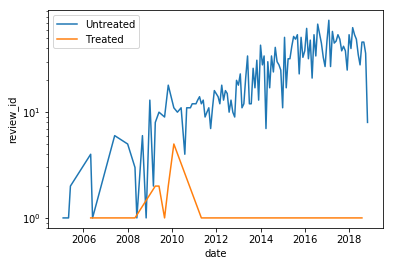

In [9]:
# For Vanessa only
# user_treat, merged = question3(df_test, file_treatment)

In [ ]:
user_treat, merged = question3(df_review,file_treatment)

Given that the treatment was random, we would expect to see the number of reviews for both the treatment and control group follow a similar trend over time. However, we see the number of reviews posted in treatment group decline sharply after the beginning of 2010, suggesting that this is not a great comparison group for our analysis.

# Changing comparison group

We clearly created some issues in the way we analyzed our sample. In this section we are going to use a more comparable group. 

 1. using the criteria described in the intro, construct the original set of users from which the treatment group was selected. 
 - extracts the users from the this group wich are not in the treatment group - this will be our control group.
 - using this new control group, plot the log number of reviews in each month for treatment and control
 - finally plot the differences of the outcome, however make sure to remove (subtract) the log of the number of individuals in each group to obtain the plot of the log number of reviews per user - otherwise your intercept won't be around 0!
 
Here are the plots I got: 

In [10]:
###QUESTION 4###

# 4.1 Construct the original set of users from which the treatment group was selected
jan10 = df_review.loc[(df_review.date < '2010-02-01') & (df_review.date >= '2010-01-01')]
merged_new = jan10.merge(treatment,left_on='user_id',right_on='treatment',how='outer')
merged_new.treatment = merged_new.treatment.notnull()

treatment_group = pd.DataFrame(merged_new.loc[merged_new.treatment == True].user_id)
treatment_total = df_review.merge(treatment_group,on = 'user_id',how = 'right')
treat = treatment_total.groupby(pd.Grouper(key='date', freq='Q')).nunique()
# treat = treat.loc[(treat!=0).any(axis=1)]
treat.drop(columns = ["date"], inplace = True)
# treat["treat_diff"] = treat["review_id"] - treat["user_id"]

# 4.2 Construct control group
control_group = pd.DataFrame(merged_new.loc[merged_new.treatment == False].user_id)
control_total = df_review.merge(control_group,on = 'user_id',how = 'right')
un = control_total.groupby(pd.Grouper(key='date', freq='Q')).nunique()
# un = un.loc[(un!=0).any(axis=1)]
un.drop(columns = ["date"], inplace = True)
# un["untreated_diff"] = treat["review_id"] - treat["user_id"]

NameError: name 'df_review' is not defined

In [11]:
# For Vanessa only
###QUESTION 4

# 4.1 Construct the original set of users from which the treatment group was selected
jan10 = df_test.loc[(df_test.date < '2010-02-01') & (df_test.date >= '2010-01-01')]
merged_new = jan10.merge(treatment,left_on='user_id',right_on='treatment',how='outer')
merged_new.treatment = merged_new.treatment.notnull()

treatment_group = pd.DataFrame(merged_new.loc[merged_new.treatment == True].user_id)
treatment_total = df_test.merge(treatment_group,on = 'user_id',how = 'right')
treat = treatment_total.groupby(pd.Grouper(key='date', freq='Q')).nunique()
# treat = treat.loc[(treat!=0).any(axis=1)]
treat.drop(columns = ["date"], inplace = True)
# treat["treat_diff"] = treat["review_id"] - treat["user_id"]

# 4.2 Construct control group
control_group = pd.DataFrame(merged_new.loc[merged_new.treatment == False].user_id)
control_total = df_test.merge(control_group,on = 'user_id',how = 'right')
un = control_total.groupby(pd.Grouper(key='date', freq='Q')).nunique()
# un = un.loc[(un!=0).any(axis=1)]
un.drop(columns = ["date"], inplace = True)
# un["untreated_diff"] = treat["review_id"] - treat["user_id"]

In [ ]:
# 4.3: plot number of reviews for each group
plt.figure()
plt.plot(un.index, un["review_id"], color = "tab:blue", label = "Untreated")
plt.plot(treat.index, treat["review_id"], color = "tab:orange", label = "Treated")
plt.ylabel("review_id")
plt.xlabel('date')
plt.yscale("log")
plt.legend()

In [ ]:
#4.4: plot number of reviews for control and treatment group #####WHY IS THIS NOT WORKING???####
dstart = datetime.datetime(2008,1,1)
dend = datetime.datetime(2020,6,1)

mod = un.merge(treat,left_index=True,right_index=True,how="inner", suffixes = ("_control", "_treat"))
mod['control_diff'] = np.log(mod['review_id_control']) - np.log(mod['user_id_control'])
mod['treated_diff'] = np.log(mod['review_id_treat']) - np.log(mod['user_id_treat'])
mod['diff'] = mod['treated_diff']-mod['control_diff'] 
plt.figure()
plt.plot(mod.index,mod['diff'])
plt.xlim(dstart, dend)
plt.ylim(-.6,0.5)
plt.ylabel("diff")
plt.xlabel('date')

In [ ]:
df_local = solution.question4(df_local,user_treat)

# Using activity per user and time

We are now interested in conducting some inference on our results. However we remember that the level of randomization is at the `user` and not at the `review`. Hence we now decide to construct observations at the `(user,year)` level. We decide to use years instead of months because the probability at the month level is too low.

 1. Construct a DataFrame with all `(user,year)` pairs and a column called `post` which is equal to 1 if the user posted in that year and 0 if he didn't. To construct such dataframe I used the `pd.MultiIndex.from_product` function, but one could use a `merge` instead.
 2. Use this newly created DataFrame to plot the level for each group, and to plot the difference between the two.
 
Here are the plots I constructed:

In [135]:
# 5.1 Construct dataframe with user, year pairs, post binary column if user posted in that year, and 0 if not

# Construct Treatment Part of the dataframe

treatment_total["year"] = treatment_total["date"].dt.year
treat_index = pd.MultiIndex.from_product([treatment_total["user_id"].unique(), treatment_total["year"].unique()]).to_frame().dropna(axis = 0)

treat_tab = treatment_total.groupby(["user_id", "year"]).count()
treat_tab["treated"] = 1
treat_tab["post"] = treat_tab["review_id"] > 0 

user_year_treat = treat_index.merge(treat_tab, how = "left", right_on = ["user_id", "year"], left_index = True, suffixes = ("", "_treat"))
user_year_treat.fillna(0, inplace = True)

In [136]:
# Construct Control Part of the dataframe

control_total["year"] = control_total["date"].dt.year
control_index = pd.MultiIndex.from_product([control_total["user_id"].unique(), control_total["year"].unique()]).to_frame().dropna(axis = 0)

control_tab = control_total.groupby(["user_id", "year"]).count()
control_tab["treated"] = 0
control_tab["post"] = control_tab["review_id"] > 0 

user_year_control = control_index.merge(control_tab, how = "left", right_on = ["user_id", "year"], left_index = True, suffixes = ("", ""))
user_year_control.fillna(0, inplace = True)

In [137]:
# Concatenate Treatment and Control Parts of Dataframe
df_user_year = pd.concat([user_year_treat, user_year_control], axis = 0, sort = False)
df_user_year.rename(columns = {0: "user", 1: "year_collected"}, inplace = True)

In [138]:
# 5.2 Plot Level for Treatment and Control Group, and Plot Difference
df_user_year_tab = df_user_year.groupby(["treated", "year"]).count()
df_user_year_tab

user  year_collected  date  review_id  post
treated year                                               
0.0     2007.0     4               4     4          4     4
        2010.0    11              11    11         11    11
1.0     2007.0     1               1     1          1     1
        2010.0     5               5     5          5     5

Text(0, 0.5, 'Activity Level')

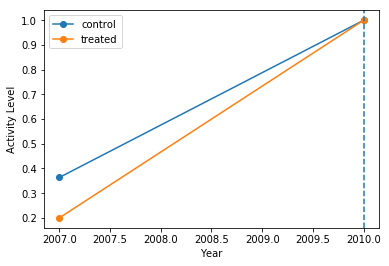

In [143]:
control_prop_tab = df_user_year_tab.loc[0, :]
treat_prop_tab = df_user_year_tab.loc[1, :]

plt.figure()
plt.plot(control_prop_tab.index, control_prop_tab["post"]/control_total["user_id"].nunique(), marker = "o", label = "control")
plt.plot(treat_prop_tab.index, treat_prop_tab["post"]/treatment_total["user_id"].nunique(), marker = "o", label = "treated")
plt.axvline(x = 2010, linestyle = "--")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Activity Level")

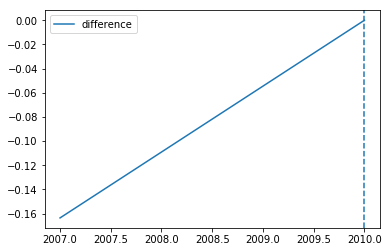

In [146]:
plt.figure()
plt.plot(control_prop_tab.index, treat_prop_tab["post"]/treatment_total["user_id"].nunique() - control_prop_tab["post"]/control_total["user_id"].nunique(), label = "difference")
plt.axvline(x = 2010, linestyle = "--")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Activity Level Difference")

In [83]:
df_local_user = solution.question5(df_local,user_treat)

NameError: name 'solution' is not defined

In [ ]:
df_local_user

# Constructing confidence intervals


In this final question our goal is to add some inference to our plot. We are going to simply use the asymptotic variance implied by the OLS formula. Do the following:

 1. create a function that will take a dataframe containing the columns `post` and `treat` and returns the OLS $\hat{\beta}$ estimate of `post` on `treat` together with the estimate of the variance of $\hat{\beta}$ (Remember that in this simple case $\hat{\beta} = cov(y,x)/var(x)$ and that the variance is $1/(n \cdot var(x))$. Return the results as a new dataframe with one row and 2 columns.
 2. apply your function to your data from question 5 for each `year` (you can do that using `pd.Grouper(freq='Y',key='date')` within a `groupby` and use the `apply` method.
 3. use your grouped results to plot the estimates together with their 95% asymptotic confidence intervals
 4. comment on the results, in particular on the dates before the start of the experiment.
 
Below is the plot that I got:

In [ ]:
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 3})


In [ ]:
solution.question6(df_local_user)

Congrats, you are done!